# Modeling Phase

In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from datetime import timedelta
import xgboost as xgb
import operator
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from isoweek import Week

from utils import *
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

In [3]:
def rmspe(y, yhat):
    '''
    Root Mean Square Percentage Error
    '''
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def get_elapsed(df, field, pre):
    '''
    cumulative counting across a sorted dataframe. Given a particular field fld to monitor, 
    this function will start tracking time since the last occurrence of that field. 
    When the field is seen again, the counter is set to zero.
    Upon initialization, this will result in datetime na's until the field is encountered. 
    '''
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    for s, v, d in zip(df.Store.values, df[field].values, pd.to_datetime(df.Date).values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: 
            last_date = d
        res.append((abs(d - last_date).astype('timedelta64[D]') / day1))
    df[pre + field] = res

In [4]:
def build_features(features, data):
    '''
    create model training features 
    takes in an existing feature set and dataframe
    returns dataframe
    '''
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features += ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday']

    # Label encode some features
    features += ['StoreType', 'Assortment', 'StateHoliday']
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # date features 
    features += ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Weekofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
                     'Is_year_start', 'Elapsed']
    transform_date(data, 'Date', drop=False)

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features += ['CompetitionOpen']
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features += ['PromoOpen']
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.Weekofyear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features += ['IsPromoMonth']
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
                
           
    # lag features 
    columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']
    df = data[columns]

    for field in ['Promo', 'StateHoliday', 'SchoolHoliday']:
        df = df.sort_values(['Store', 'Date'])
        get_elapsed(df, field, 'DaysAfter')
        df = df.sort_values(['Store', 'Date'], ascending=[True, False])
        get_elapsed(df, field, 'DaysBefore')

    df = df.sort_values(['Store', 'Date'])
    # set date as index
    df = df.set_index("Date")

    # fill NAN values if True
    fill_na = False
    columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
    if fill_na:
        for o in ['DaysBefore', 'DaysAfter']:
            for p in columns:
                a = o + p
                df[a] = df[a].fillna(0).astype(int)

    # rolling means
    bwd = df[['Store'] + columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()
    fwd = df[['Store'] + columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

    # drop and reset index
    bwd.drop('Store', axis=1, inplace=True)
    bwd.reset_index(inplace=True)

    fwd.drop('Store', axis=1, inplace=True)
    fwd.reset_index(inplace=True)

    df.reset_index(inplace=True)

    # merge rolling means to df
    df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
    df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

    # drop 
    df.drop(columns, axis=1, inplace=True)

    features += list(df.columns[2:])
    # merge data frames 
    data = data.merge(df, on=['Date', 'Store'], how='left')

    features += ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear']
    data['CompetitionOpenSinceYear'] = data.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    data['CompetitionOpenSinceMonth'] = data.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    data['Promo2SinceYear'] = data.Promo2SinceYear.fillna(1900).astype(np.int32)
    data['Promo2SinceWeek'] = data.Promo2SinceWeek.fillna(1).astype(np.int32)
    
    return data


# read in data 
print('Read in data')
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("data/train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("data/test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("data/store.csv")

# only going to use open stores with Sales greater than 0
train = train[(train.Open == 1) & (train.Sales > 0)]


print('Join with store')
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')


# create features 
features = []
print('Building Training Features')
train = build_features(features, train)
print('Building Testing Features')
test = build_features([], test)


# sort by date 
train.sort_values('Date', inplace=True)
test.sort_values('Date', inplace=True)

Read in data
Join with store
Building Training Features
Building Testing Features


# Train on all Stores 

In [8]:
MAX_ROUNDS = 100000
EARLY_STOP = 125

my_params = {
#     'seed': 10,
    'device':'gpu',
    'metric': 'mse',
    'objective': 'regression',
    'max_depth': 7,
    'num_leaves': 25,
    'bagging_fraction': 0.75,
    'feature_fraction': 0.75,
    'min_data_in_leaf': 300, # important 
    'learning_rate': 0.1, # change later - trick after found correct num of round multiply num steps by alpha and divide learning rate by alpha
    
}

# data split 
val_size = test.Date.nunique()
X_train = train[train.Date <= (train.Date.max() - timedelta(val_size))]
X_valid = train[train.Date > (train.Date.max() - timedelta(val_size))]
print('Created validation set -- train size: days - {}, val size: days - {}'.format(len(X_train), val_size))

# log sales 
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)

# create datasets
dtrain = lgb.Dataset(X_train[features], y_train)
dvalid = lgb.Dataset(X_valid[features], y_valid, reference=dtrain)

print('Train a LGB model')
bst = lgb.train(my_params, dtrain, num_boost_round=MAX_ROUNDS, 
                valid_sets=[dtrain, dvalid], early_stopping_rounds=EARLY_STOP, verbose_eval=250)

# get preds for validation set 
yhat_train = bst.predict(X_train[features], num_iteration=bst.best_iteration or MAX_ROUNDS)
yhat = bst.predict(X_valid[features], num_iteration=bst.best_iteration or MAX_ROUNDS)

# errors 
error_train = rmspe(X_train.Sales.values, np.expm1(yhat_train))
print('Training RMSPE: {:.6f}'.format(error_train))

error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('Validation RMSPE: {:.6f}'.format(error))

Created validation set -- train size: days - 798454, val size: days - 48
Train a LGB model
Training until validation scores don't improve for 125 rounds.
[250]	training's l2: 0.0384685	valid_1's l2: 0.041056
[500]	training's l2: 0.0242859	valid_1's l2: 0.0279212
[750]	training's l2: 0.0191392	valid_1's l2: 0.0229741
[1000]	training's l2: 0.0163503	valid_1's l2: 0.0213658
[1250]	training's l2: 0.0147957	valid_1's l2: 0.0198974
[1500]	training's l2: 0.0135352	valid_1's l2: 0.0189025
[1750]	training's l2: 0.0125444	valid_1's l2: 0.0182176
[2000]	training's l2: 0.0118384	valid_1's l2: 0.0174807
[2250]	training's l2: 0.0112627	valid_1's l2: 0.0170966
[2500]	training's l2: 0.0107452	valid_1's l2: 0.0166783
[2750]	training's l2: 0.0103833	valid_1's l2: 0.0164143
[3000]	training's l2: 0.0100691	valid_1's l2: 0.0162199
[3250]	training's l2: 0.00976477	valid_1's l2: 0.0159888
[3500]	training's l2: 0.00946606	valid_1's l2: 0.0157295
[3750]	training's l2: 0.00922865	valid_1's l2: 0.0155312
[4000]	

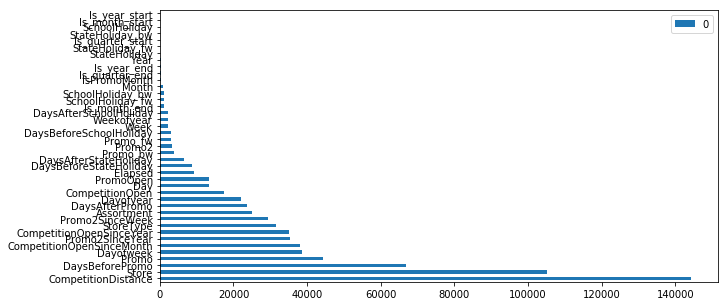

In [9]:
# feature importance plot 
import matplotlib.pyplot as plt
%matplotlib inline

fi = pd.DataFrame.from_dict(dict(zip(X_train[features].columns, bst.feature_importance('gain'))), orient='index').sort_values(0, ascending=False)
fi.plot(kind='barh', figsize=(10, 5));

# Train on Individual Store

In [10]:
store_number = 1017

store_train = X_train[X_train.Store == store_number]
store_valid = X_valid[X_valid.Store == store_number]

print('Created validation set -- train size: days - {}, val size: days - {}'.format(len(store_train), len(store_valid)))


store_params = {
    'seed': 100,
    'device':'gpu',
    'metric': 'mse',
    'objective': 'regression',
    'max_depth': 20,
    'num_leaves': 80,
    'bagging_fraction': 0.75,
    'feature_fraction': 0.75,
    'min_data_in_leaf': 300, # important 
    'learning_rate': 0.1, # change later - trick after found correct num of round multiply num steps by alpha and divide learning rate by alpha
    
}

# log sales 
y_train = np.log1p(store_train.Sales)
y_valid = np.log1p(store_valid.Sales)

# create datasets
dtrain = lgb.Dataset(store_train[features], y_train)
dvalid = lgb.Dataset(store_valid[features], y_valid, reference=dtrain)

print('Train a LGB model')
bst_individual = lgb.train(store_params, dtrain, num_boost_round=MAX_ROUNDS, 
                valid_sets=[dtrain, dvalid], early_stopping_rounds=EARLY_STOP, verbose_eval=250)

# get preds for validation set 
yhat_train = bst_individual.predict(store_train[features], num_iteration=bst_individual.best_iteration or MAX_ROUNDS)
yhat = bst_individual.predict(store_valid[features], num_iteration=bst_individual.best_iteration or MAX_ROUNDS)

# errors 
error_train = rmspe(store_train.Sales.values, np.expm1(yhat_train))
print('Training RMSPE: {:.6f}'.format(error_train))

error = rmspe(store_valid.Sales.values, np.expm1(yhat))
print('Validation RMSPE: {:.6f}'.format(error))

Created validation set -- train size: days - 726, val size: days - 41
Train a LGB model
Training until validation scores don't improve for 125 rounds.
[250]	training's l2: 0.0157606	valid_1's l2: 0.0155319
[500]	training's l2: 0.0138201	valid_1's l2: 0.0127435
[750]	training's l2: 0.0130189	valid_1's l2: 0.0121531
[1000]	training's l2: 0.0125754	valid_1's l2: 0.0117097
[1250]	training's l2: 0.0122715	valid_1's l2: 0.011493
[1500]	training's l2: 0.0120443	valid_1's l2: 0.0113029
[1750]	training's l2: 0.0118714	valid_1's l2: 0.0110038
[2000]	training's l2: 0.0117307	valid_1's l2: 0.0105042
[2250]	training's l2: 0.0116056	valid_1's l2: 0.0102916
[2500]	training's l2: 0.0114914	valid_1's l2: 0.0101502
[2750]	training's l2: 0.0113866	valid_1's l2: 0.00999812
[3000]	training's l2: 0.0112902	valid_1's l2: 0.00988324
[3250]	training's l2: 0.0112016	valid_1's l2: 0.00973274
[3500]	training's l2: 0.0111202	valid_1's l2: 0.0096462
[3750]	training's l2: 0.0110453	valid_1's l2: 0.0095057
[4000]	tra

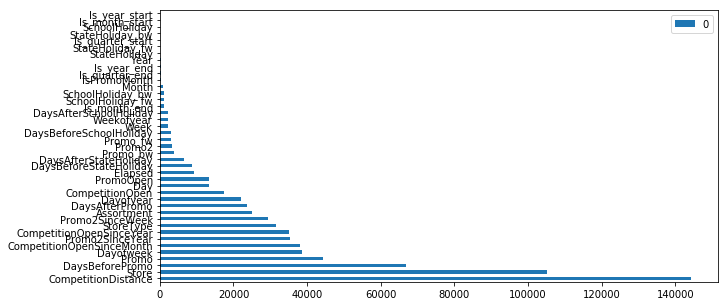

In [11]:
# feature importance plot for individual store 
import matplotlib.pyplot as plt
%matplotlib inline

fi = pd.DataFrame.from_dict(dict(zip(X_train[features].columns, bst.feature_importance('gain'))), orient='index').sort_values(0, ascending=False)
fi.plot(kind='barh', figsize=(10, 5));

# Future Predictions

In [12]:
store_number = 1017

store_train = X_train[X_train.Store == store_number]
store_valid = X_valid[X_valid.Store == store_number]

In [13]:
def create_pred_df(model, store_train, store_valid, features=features):
    '''
    takes in a model and store dataframes
    prints training and validation errors
    returns prediction dataframe
    '''
    # predict 
    yhat_train = model.predict(store_train[features], num_iteration=model.best_iteration or MAX_ROUNDS)
    yhat = model.predict(store_valid[features], num_iteration=model.best_iteration or MAX_ROUNDS)

    # errors 
    error_train = rmspe(store_train.Sales.values, np.expm1(yhat_train))
    print('Training RMSPE: {:.6f}'.format(error_train))

    error = rmspe(store_valid.Sales.values, np.expm1(yhat))
    print('Validation RMSPE: {:.6f}'.format(error))
    
    preds_df_train = store_train[['Date', 'Sales']]
    preds_df_train['preds'] = np.round(np.expm1(yhat_train))
    preds_df_train['set'] = 'train'

    preds_df_valid = store_valid[['Date', 'Sales']]
    preds_df_valid['preds'] = np.round(np.expm1(yhat))
    preds_df_valid['set'] = 'valid'

    preds = pd.concat((preds_df_train, preds_df_valid), axis=0).set_index('Date')
    return preds

In [14]:
def plot_preds(preds):
    '''
    plots the true values vs predictions based on the preds dataframe
    '''
    preds[['preds','Sales']].plot(figsize=(15, 5))
    plt.axvline(preds[preds['set'] == 'train'].iloc[-1].name, c='r', linewidth=3)
    plt.text(preds[preds['set'] == 'train'].iloc[int(sum(preds['set'] == 'train') / 2)].name, 14000, 'train')
    plt.text(preds[preds['set'] == 'valid'].iloc[int(sum(preds['set'] == 'valid') / 2)].name, 14000, 'valid')
    plt.legend(loc='left')
    plt.ylabel('Sales')
    plt.title('Predictions vs True Values');

### all store model predictions 

Training RMSPE: 0.058151
Validation RMSPE: 0.113102


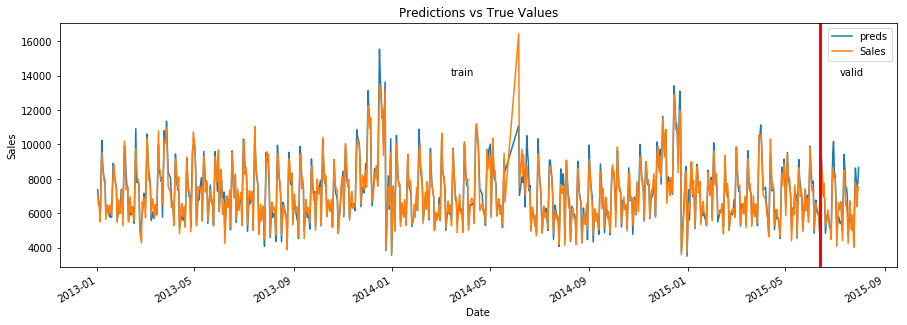

In [15]:
# all store model 
preds = create_pred_df(bst, store_train, store_valid)
plot_preds(preds)

### individual store model predictions

Training RMSPE: 0.109787
Validation RMSPE: 0.100603


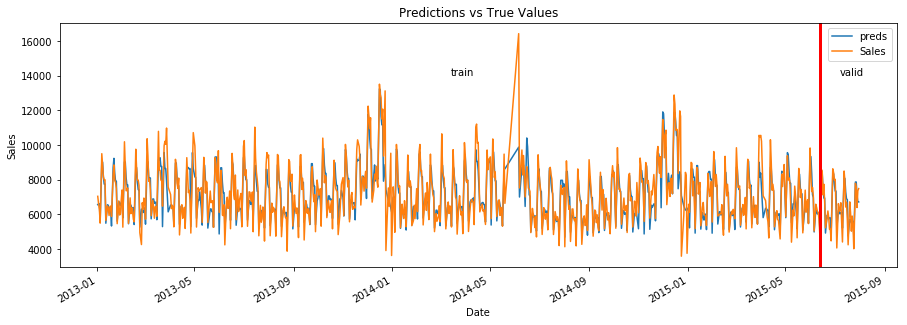

In [16]:
preds = create_pred_df(bst_individual, store_train, store_valid)
plot_preds(preds)

In [19]:
# ALL stores 
test_2 = pd.read_csv("data/test.csv", parse_dates=[3], dtype=types)
store_2 = pd.read_csv("data/store.csv")

def get_future_pred(model, store_number, pred_date='2015-09-01', features=features, promo=0):
    '''
    input - model, store number, and future date
    outputs future prediction dataframe for store number
    '''
    store_df = store_2[store_2.Store == store_number].reset_index(drop=True)
    date_data = test_2[test_2.Date == pred_date].iloc[:1][['Date', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday']].reset_index()
    final_df = pd.concat((store_df, date_data), axis=1)
    final_df['Promo'] = promo
    final_df['Open'] = 1
    final_df = build_features([], final_df)
    return np.expm1(model.predict(final_df[features]))

store_number = 1017
# promo = 0
# get_future_pred(bst, store_number, pred_date='2015-09-17', features=features, promo=promo)

all_future = pd.DataFrame()
all_pred_promo = []
all_pred = []
all_dates = test_2.Date.unique()
for date in all_dates:
    for pr in [0, 1]:
        if pr == 0:
            all_pred.append(get_future_pred(bst, store_number, pred_date=date, features=features, promo=pr)[0])
        else:
            all_pred_promo.append(get_future_pred(bst, store_number, pred_date=date, features=features, promo=pr)[0])

all_future['preds no promo'] = all_pred
all_future['preds promo'] = all_pred_promo
all_future['Date'] = all_dates

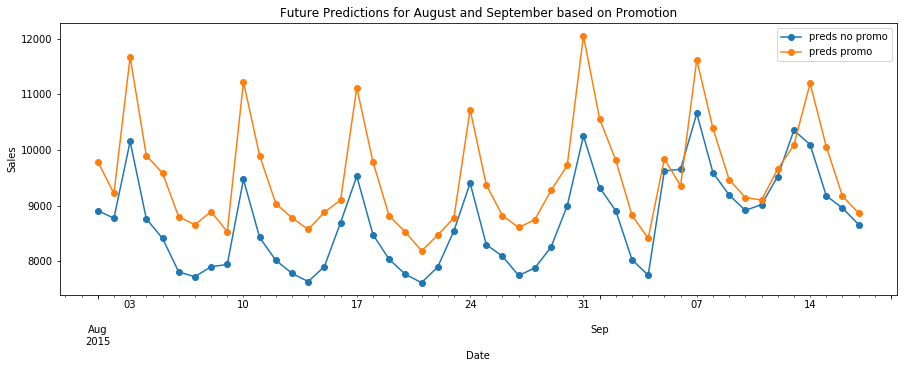

In [20]:
# future date plot
all_future.set_index('Date').plot(figsize=(15, 5), marker='o')
plt.ylabel('Sales')
plt.title('Future Predictions for August and September based on Promotion');